<a href="https://colab.research.google.com/github/Adhishreya/Mlbasics/blob/master/LONGER_TRain_of_proj_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -o /content/drive/MyDrive/he1.zip
# !unzip -o tweets_research.zip -d ./


Streaming output truncated to the last 5000 lines.
  inflating: he1/981972resized4rotated_md_he.jpg  
  inflating: he1/982013resized1rotated_md_he.jpg  
  inflating: he1/982013resized2rotated_md_he.jpg  
  inflating: he1/982013resized3rotated_md_he.jpg  
  inflating: he1/982013resized4rotated_md_he.jpg  
  inflating: he1/982018resized1rotated_md_he.jpg  
  inflating: he1/982018resized2rotated_md_he.jpg  
  inflating: he1/982018resized3rotated_md_he.jpg  
  inflating: he1/982018resized4rotated_md_he.jpg  
  inflating: he1/982076resized1rotated_md_he.jpg  
  inflating: he1/982076resized2rotated_md_he.jpg  
  inflating: he1/982076resized3rotated_md_he.jpg  
  inflating: he1/982076resized4rotated_md_he.jpg  
  inflating: he1/982105resized1rotated_md_he.jpg  
  inflating: he1/982105resized2rotated_md_he.jpg  
  inflating: he1/982105resized3rotated_md_he.jpg  
  inflating: he1/982105resized4rotated_md_he.jpg  
  inflating: he1/982129resized1rotated_md_he.jpg  
  inflating: he1/982129resized2

# Libraries

In [3]:
import keras
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.callbacks import EarlyStopping
from keras.layers import Input
from keras.models import load_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

# Model architecture

In [4]:
def ConvLayers(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3,3,activation='relu'))
    model.add(MaxPooling2D((2,2),strides=(1,1),padding="same"))

In [5]:
def FCLayers(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [6]:
def VGG16_arc():
    model=Sequential()
    ConvLayers(2,model,64)
    ConvLayers(2,model,128)
    ConvLayers(3,model,256)
    ConvLayers(3,model,512)
    ConvLayers(3,model,512)
    model.add(Flatten())
    FCLayers(model)
    FCLayers(model)
    model.add(Dense(37,activation='sigmoid'))
    #model.add(Dense(3,activation='softmax'))
    return model

In [7]:
#Model compilation
optimizer = RMSprop(lr=1e-4) #can be later tweaked
model = VGG16_arc()
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy']) 
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [8]:
shuf=pd.read_csv('/content/drive/MyDrive/shuffled.csv')
shuf.head()
cols=shuf.columns[1:]

In [9]:
shuf.shape

(246312, 38)

In [10]:
X=shuf['GalaxyID'].values.tolist()
Y=shuf[cols].values.tolist()
# x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state=42)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
path='/content/he1/'
sam=len(y_train)

# Generator Function

In [11]:
def Generate_train(x_train,y_train,bs):
    while(True):
        b_start=0
        b_end=bs
        L=len(y_train)
        while b_start<L:            
            limit=min(b_end,L)
            x_samp=x_train[b_start:limit]
            y_samp=y_train[b_start:limit]
            X_train=[]
            Y_train=[]
            for i in range(0,len(x_samp)):
#                 print(i)
                X_train.append(cv2.cvtColor(cv2.imread(path+str(x_samp[i])+'.jpg') ,cv2.COLOR_BGR2RGB))
                Y_train.append(y_samp[i])
            X_train=np.array(X_train)
            Y_train=np.array(Y_train)
            yield X_train,Y_train
            b_start+=bs
            b_end+=bs         

In [12]:
batch_size=32
train_gen=Generate_train(x_train,y_train,batch_size)

In [13]:
optimizer = RMSprop(lr=1e-4) #can be later tweaked
model = VGG16_arc()
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy']) 
steps=len(x_train)//batch_size

In [14]:
def Generate_test(x_test,y_test,bs):
    while(True):
        b_start=0
        b_end=bs
        L=len(y_test)
        while b_start<L:            
            limit=min(b_end,L)
            x_samp=x_test[b_start:limit]
            y_samp=y_test[b_start:limit]
            X_test=[]
            Y_test=[]
            for i in range(0,len(x_samp)):
#                 print(i)
                X_test.append(cv2.cvtColor(cv2.imread(path+str(x_samp[i])+'.jpg') ,cv2.COLOR_BGR2RGB))
                Y_test.append(y_samp[i])
            X_test=np.array(X_test)
            Y_test=np.array(Y_test)
            yield X_test,Y_test
            b_start+=bs

            b_end+=bs         

In [15]:
# stop=EarlyStopping(monitor='val_loss',min_delta=0,patience=3)
stop=EarlyStopping(monitor='val_loss',verbose=1,min_delta=0,patience=5)
batch_size=32
test_gen=Generate_test(x_test,y_test,batch_size)
val_steps=len(x_test)//batch_size

In [16]:
model.build(input_shape=(None,224,224,3))

checkpoint_filepath = 'weight.hdf5'
cp_callback =keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True)

model.fit(train_gen,epochs=50,verbose=1,batch_size=None,steps_per_epoch=steps,callbacks=[cp_callback],validation_data=test_gen,validation_steps=val_steps)
# model.fit(x=img_train, y=y_train, batch_size = 32, epochs = 50)

Epoch 1/50
6157/6157 [==============================] - 291s 44ms/step - loss: 0.0241 - accuracy: 0.6164 - val_loss: 0.0159 - val_accuracy: 0.6850
Epoch 2/50
6157/6157 [==============================] - 270s 44ms/step - loss: 0.0159 - accuracy: 0.6775 - val_loss: 0.0166 - val_accuracy: 0.6617
Epoch 3/50
6157/6157 [==============================] - 269s 44ms/step - loss: 0.0142 - accuracy: 0.7042 - val_loss: 0.0129 - val_accuracy: 0.7291
Epoch 4/50
6157/6157 [==============================] - 269s 44ms/step - loss: 0.0129 - accuracy: 0.7284 - val_loss: 0.0129 - val_accuracy: 0.7176
Epoch 5/50
6157/6157 [==============================] - 269s 44ms/step - loss: 0.0121 - accuracy: 0.7416 - val_loss: 0.0122 - val_accuracy: 0.7332
Epoch 6/50
6157/6157 [==============================] - 270s 44ms/step - loss: 0.0117 - accuracy: 0.7493 - val_loss: 0.0117 - val_accuracy: 0.7503
Epoch 7/50
6157/6157 [==============================] - 269s 44ms/step - loss: 0.0112 - accuracy: 0.7552 - val_loss: 0

In [17]:
model.save('final_trial.hdf5')

In [25]:
key=model.history.history.keys()
values=model.history.history

In [26]:
key

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

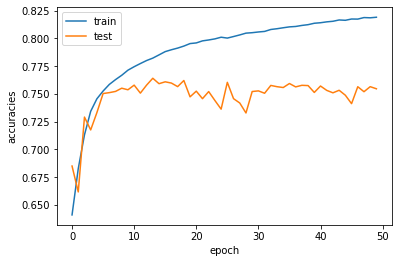

In [29]:
plt.plot(values['accuracy'])
plt.plot(values['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.legend(['train', 'test'], loc='upper left')

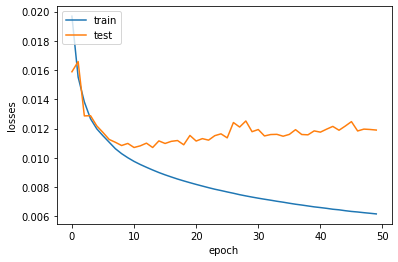

In [30]:
plt.plot(values['loss'])
plt.plot(values['val_loss'])
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['train', 'test'], loc='upper left')